## BAZI PARAMETRELER IŞIĞINDA KRONİK BÖBREK HASTALIĞI TAHMİNİ

### 1. GİRİŞ
### 2. ÖZET BİLGİ
### 3. VERİ TEMİZLİĞİ VE ANALİZ HAZIRLIĞI
### 4. VERİ KEŞFİ
### 5. TEMEL BİLEŞENLER ANALİZİ (PCA)
### 6. SONUÇ

..............................................................................................................................

### 1. GİRİŞ
Bu veri seti, 2 aylık bir süre zarfında 25 parametre ile Hindistan'da kaydedilmiştir. Hedef değişkenimiz "Kronik Böbrek Hastası" olma veya olmama durumudur. Biz, hastaları 1 değeri ile ve hasta olmayanları 0 değeri ile eşleştireceğiz.

Veri setimizde çok fazla eksik değer ve hatalı giriş var. Konumuzun sağlıkla ilgili olması nedeniyle;

- Bir hataya sebep olmaması için eksik verileri tamamlamayacağız ve 
- Bazı hastalıklarda bazı uç parametrelerin normal karşılanabilmesi nedeniyle veri aralığımızı geniş tutup mümkün olduğunca winsorize işleminden kaçınacağız.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as sts
import warnings

from scipy.stats.mstats import winsorize
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
baslik_font = {'family': 'arial', 'color': 'darkred','weight': 'bold','size': 13 }
eksen_font  = {'family': 'arial', 'color': 'darkblue','weight': 'bold','size': 10 }

In [2]:
kidney = pd.read_csv("C:\\Users\\Gunesim\\Desktop\\Ödevler\\Proje_1\\kidney_disease.csv", engine="python", encoding="utf8")

### 2. ÖZET BİLGİ
#### 2.a. Sütunlar ve İçerikleri
Öncelikle sütunları gözden geçirelim. Tüm sütunların görülebilmesi için tabloyu yan çevirelim.

In [3]:
kidney.head().T

,0,1,2,3,4
id,0,1,2,3,4
age,48,7,62,48,51
bp,80,50,80,70,80
sg,1.02,1.02,1.01,1.005,1.01
al,1,4,2,4,2
su,0,0,3,0,0
rbc,NaN,NaN,normal,normal,normal
pc,normal,normal,normal,abnormal,normal
pcc,notpresent,notpresent,notpresent,present,notpresent
ba,notpresent,notpresent,notpresent,notpresent,notpresent


In [4]:
kidney.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


#### 2.b. Sütunlardaki veri miktarları ve veri tipleri
Sütunlarda (özellikle bazı sütunlarda oldukça fazla) veri eksiği var. Bazı değerler de metin olarak saklanmış. Metin olarak saklanan verilerin içeriği genel olarak kategorik (yes-no, abnormal-normal, absent-present vb.) değişkenlerdir.

In [5]:
kidney.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
id                400 non-null int64
age               391 non-null float64
bp                388 non-null float64
sg                353 non-null float64
al                354 non-null float64
su                351 non-null float64
rbc               248 non-null object
pc                335 non-null object
pcc               396 non-null object
ba                396 non-null object
bgr               356 non-null float64
bu                381 non-null float64
sc                383 non-null float64
sod               313 non-null float64
pot               312 non-null float64
hemo              348 non-null float64
pcv               330 non-null object
wc                295 non-null object
rc                270 non-null object
htn               398 non-null object
dm                398 non-null object
cad               398 non-null object
appet             399 non-null object
pe         

Sütunlardaki boş veri miktarları aşağıda görüldüğü gibidir:

In [6]:
len(kidney)-kidney.count()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

### 3. VERİ TEMİZLİĞİ VE ANALİZ HAZIRLIĞI
#### 3.a. Sayısallaştırma
Öncelikle, metin olarak saklanan değerleri sayısal değerlere dönüştürelim. Kötü olan değerler 1, iyi olan değerler 0 olsun. Böylece, değerleri birbiri ile orantılayabilmek de mümkün olur.

Bu işlemlerin bazılarını "get_dummies" veya "LabelEncoder" metodları ile de yapabilirdik.

In [7]:
kidney[['htn','dm','cad','pe','ane']] = kidney[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})

kidney[['rbc','pc']] = kidney[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})

kidney[['pcc','ba']] = kidney[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})

kidney[['appet']] = kidney[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})

kidney['classification'] = kidney['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})

kidney.rename(columns={'classification':'class'},inplace=True)

kidney['pe'] = kidney['pe'].replace(to_replace='good',value=0)

kidney['appet'] = kidney['appet'].replace(to_replace='no',value=0)

kidney['cad'] = kidney['cad'].replace(to_replace='\tno',value=0)

kidney['dm'] = kidney['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})

kidney[["pcv", "wc", "rc"]]=kidney[["pcv", "wc", "rc"]].replace(to_replace={'\t?':np.nan})

kidney[["pcv", "wc", "rc"]]=kidney[["pcv", "wc", "rc"]].astype(float)

kidney.drop('id',axis=1,inplace=True)

#### 3.b. Boş değerler
Her ne kadar büyük miktarda veri kaybına neden olsa da, bu veri setimiz için boş değerleri doldurmak uygun olmayabilir. Bu sebeple, boşlukları doldurmak yerine hesaplamadan çıkarıyoruz. Çıkardıktan sonra geriye toplam 158 verimiz kalıyor.

In [8]:
kd=kidney.dropna(axis=0)
kd_wins=kd

print("Geriye kalan toplam veri: ", len(kd),"\n")

print("Hastalık teşhisi konulmamış : ",kd["class"].value_counts()[0])
print("Hastalık teşhisi konulmuş   : ",kd["class"].value_counts()[1])

Geriye kalan toplam veri:  158 

Hastalık teşhisi konulmamış :  115
Hastalık teşhisi konulmuş   :  43


#### 3.c. Aşırı değerler
Boxplot çizerek aşırı değerlerin mevcudiyetini kontrol edelim.

Konu sağlık olunca, uç değer kavramımızı biraz esnetmekte fayda var. Bu sebeple, boxplot'un whis değerini biraz artırarak yolumuza devam edelim.

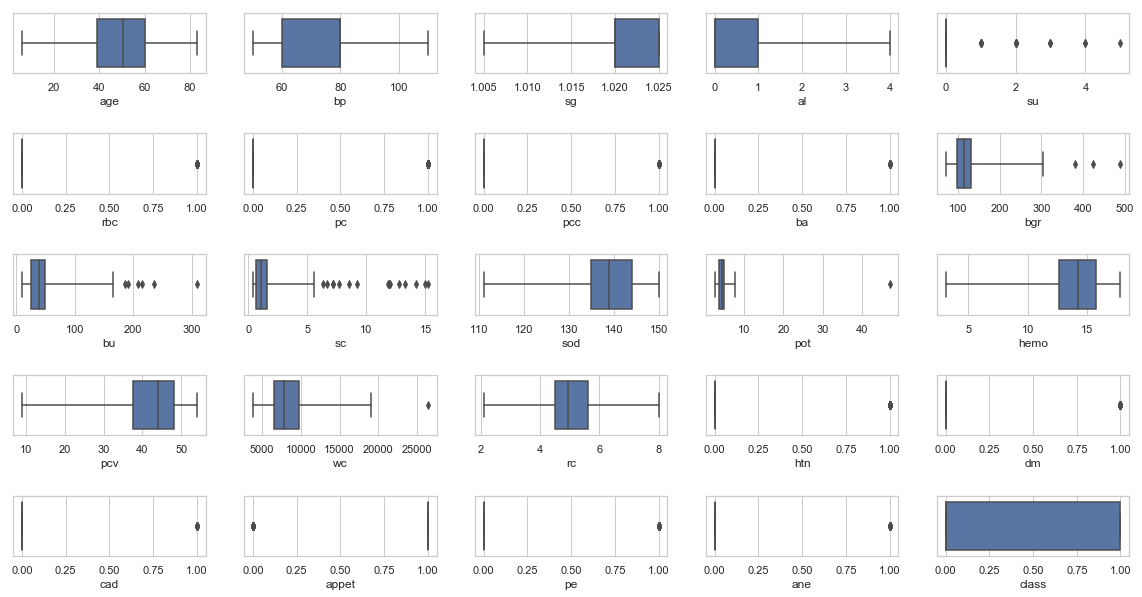

In [9]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=1, wspace=0.2)
for i in range(1,len(kd.columns)+1):
    plt.subplot(5,5,i)
    sns.boxplot(kd.iloc[:,i-1], whis=5)
plt.show()

Yukarıdaki boxplotlar incelendiğinde, 12 tane parametrede uç değerler olduğu gözlenmektedir.

Bunları winsorize edip ortadan kaldıralım. Her sütunda winsorize değerleri farklı olduğu için biz de ayrı ayrı yapalım.

In [10]:
kd_wins["bgr"]=winsorize(kd["bgr"], (0, 0.02))
kd_wins["bu"]=winsorize(kd["bu"], (0, 0.04))
kd_wins["sc"]=winsorize(kd["sc"], (0, 0.1))
kd_wins["pot"]=winsorize(kd["pot"], (0, 0.02))
kd_wins["wc"]=winsorize(kd["wc"], (0, 0.01))

### 4. VERİ KEŞFİ
#### 4.a. Hasta olma durumuna göre parametrelerin dağılımı
Alt örneklemde uç değerleri kaldırdık. Şimdi, parametrelerin hastalık teşhisi konulmuş olan ve hasta olmayan kişilerdeki dağılımlarına bakalım.

In [11]:
parametreler={"age":"yaş", "sg":"özgül ağırlık", "su":"şeker", "pc":"irin", 
              "ba":"bakteri", "bu":"kan üre", "sod":"sodyum", "hemo":"hemoglobin", 
              "wc":"beyaz kan sayımı", "htn":"hipertansiyon", "cad":"koroner arter",
              "pe":"pedal ödem", "bp":"tansiyon", "al":"albümin", "rbc":"kırmızı kan", 
              "pcc":"irin kümesi", "bgr":"kan şekeri", "sc":"serum kreatinin",
              "pot":"potasyum", "pcv":"paketlenmiş hücre hacmi", "rc":"kırmızı kan sayımı",
              "dm":"diabetes mellitus", "appet":"iştah", "ane":"anemi", "class":"hastalık durumu"}

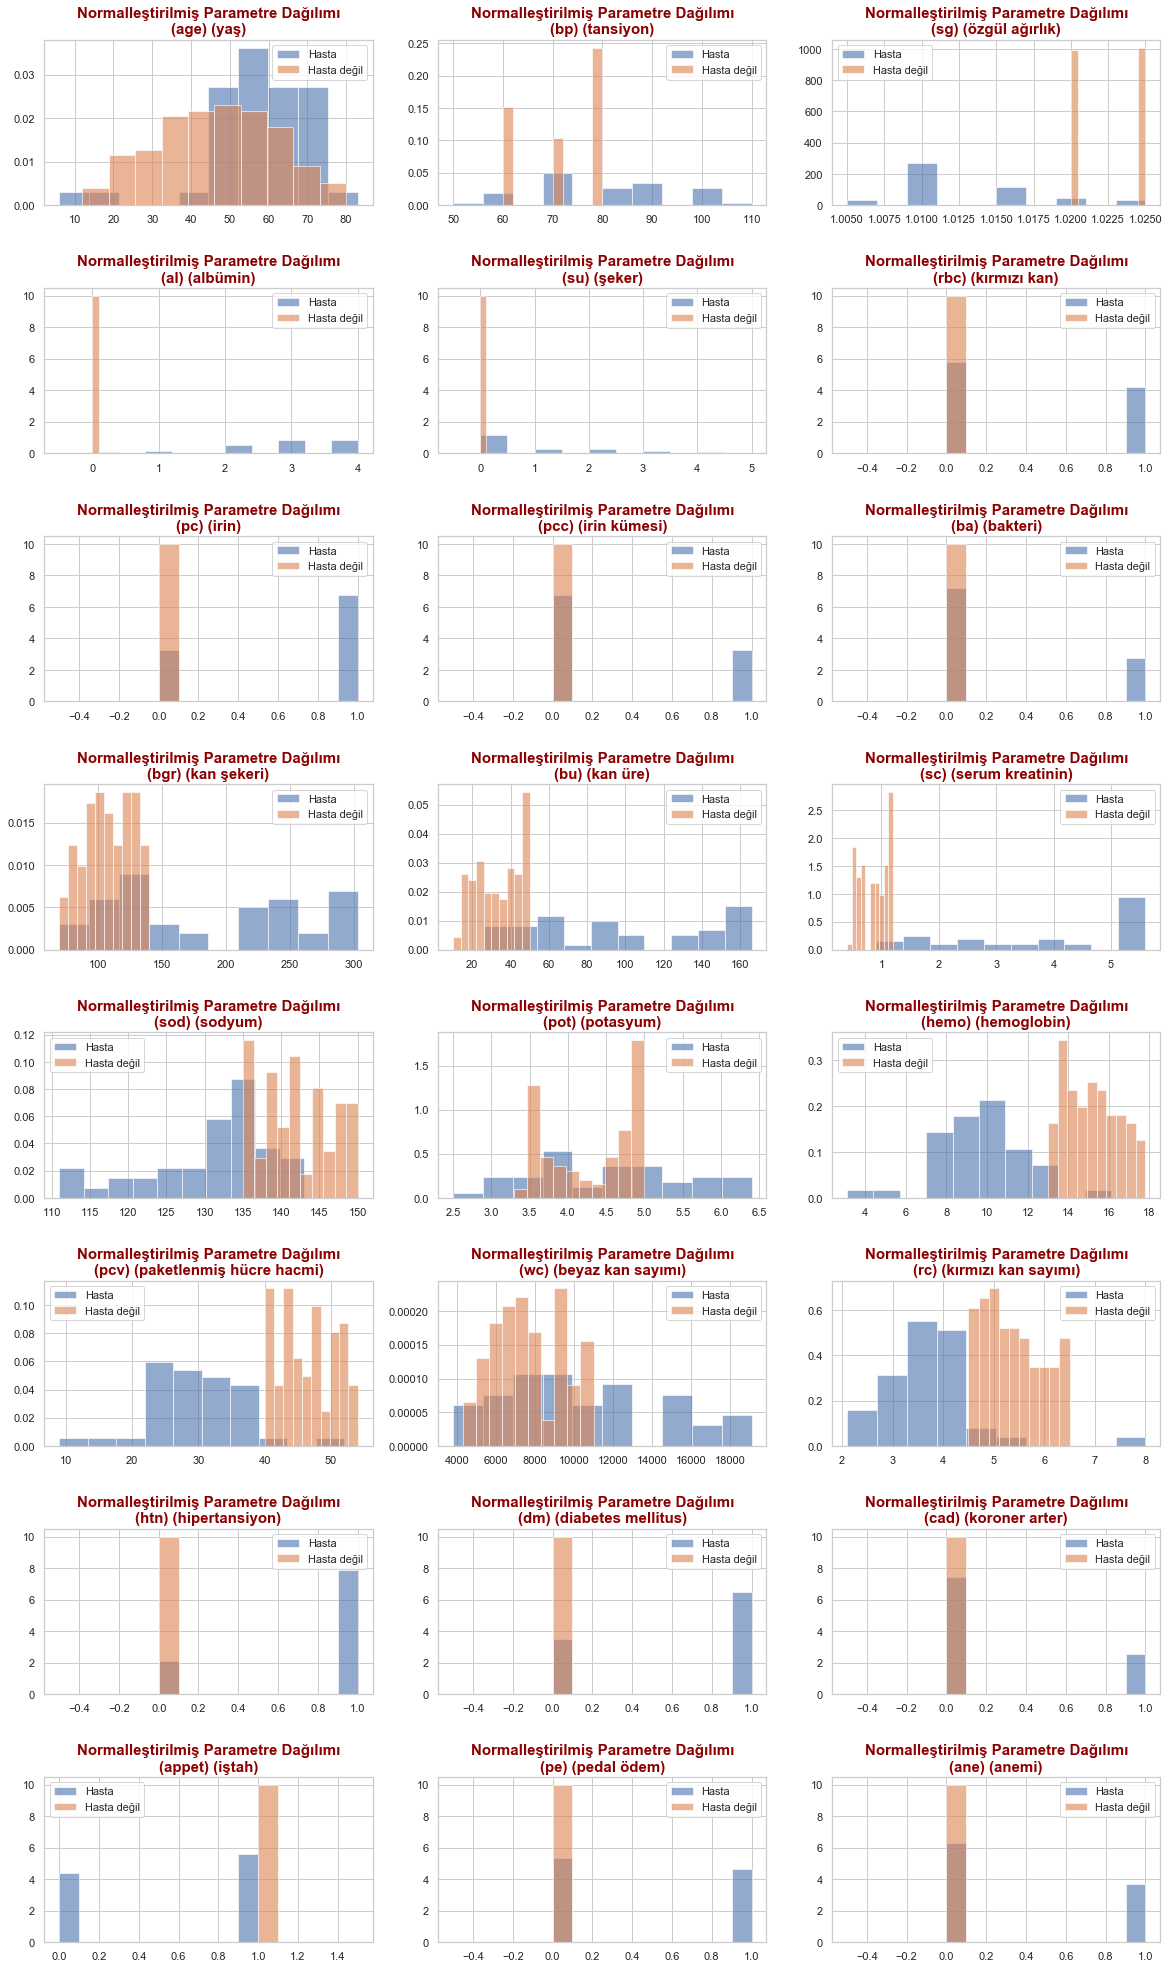

In [12]:
plt.figure(figsize=(20,35))
plt.subplots_adjust(hspace=0.5)
font_baslik={"family":"arial", "color":"darkred", "weight":"bold", "size":15}

for i in range(0, len(kd_wins.columns)-1):
    plt.subplot(8,3,i+1)
    plt.hist(kd_wins[kd_wins["class"]==1].iloc[:,i], density=True, alpha=0.6)
    plt.hist(kd_wins[kd_wins["class"]==0].iloc[:,i], density=True, alpha=0.6)
    plt.legend(["Hasta", "Hasta değil"])
    plt.ylabel
    plt.title("Normalleştirilmiş Parametre Dağılımı\n({}) ({})".format(kd_wins.columns[i], parametreler[kd_wins.columns[i]]), 
              fontdict=font_baslik)
    
plt.show()

Yukarıdaki tablolara baktığımızda;

- Hastaların yaşlarının çoğunlukla 42-72 aralığında toplandığını,

- Kan yoğunluğu, sodyum, hemoglobin, paket hücre hacmi ve kırmızı kan değerlerinin düşük olduğunu,

- Albümin, şeker, kan üre, serum kreatinin ve tansiyon değerlerinin yüksek olduğunu,

- Vücutlarında irin ve bakteriye rastlanabildiği,

- Hastalığa diabetes mellitus, koroner arter, iştahsızlık, pedal ödem, anemi sorunlarının eşlik edebildiği görülmektedir.

#### 4.b. Sürekli değişkenlerin birbirileriyle olan ilişkileri
Sürekli değişkenlerin birbiriyle olan uyumlarına bakarsak:

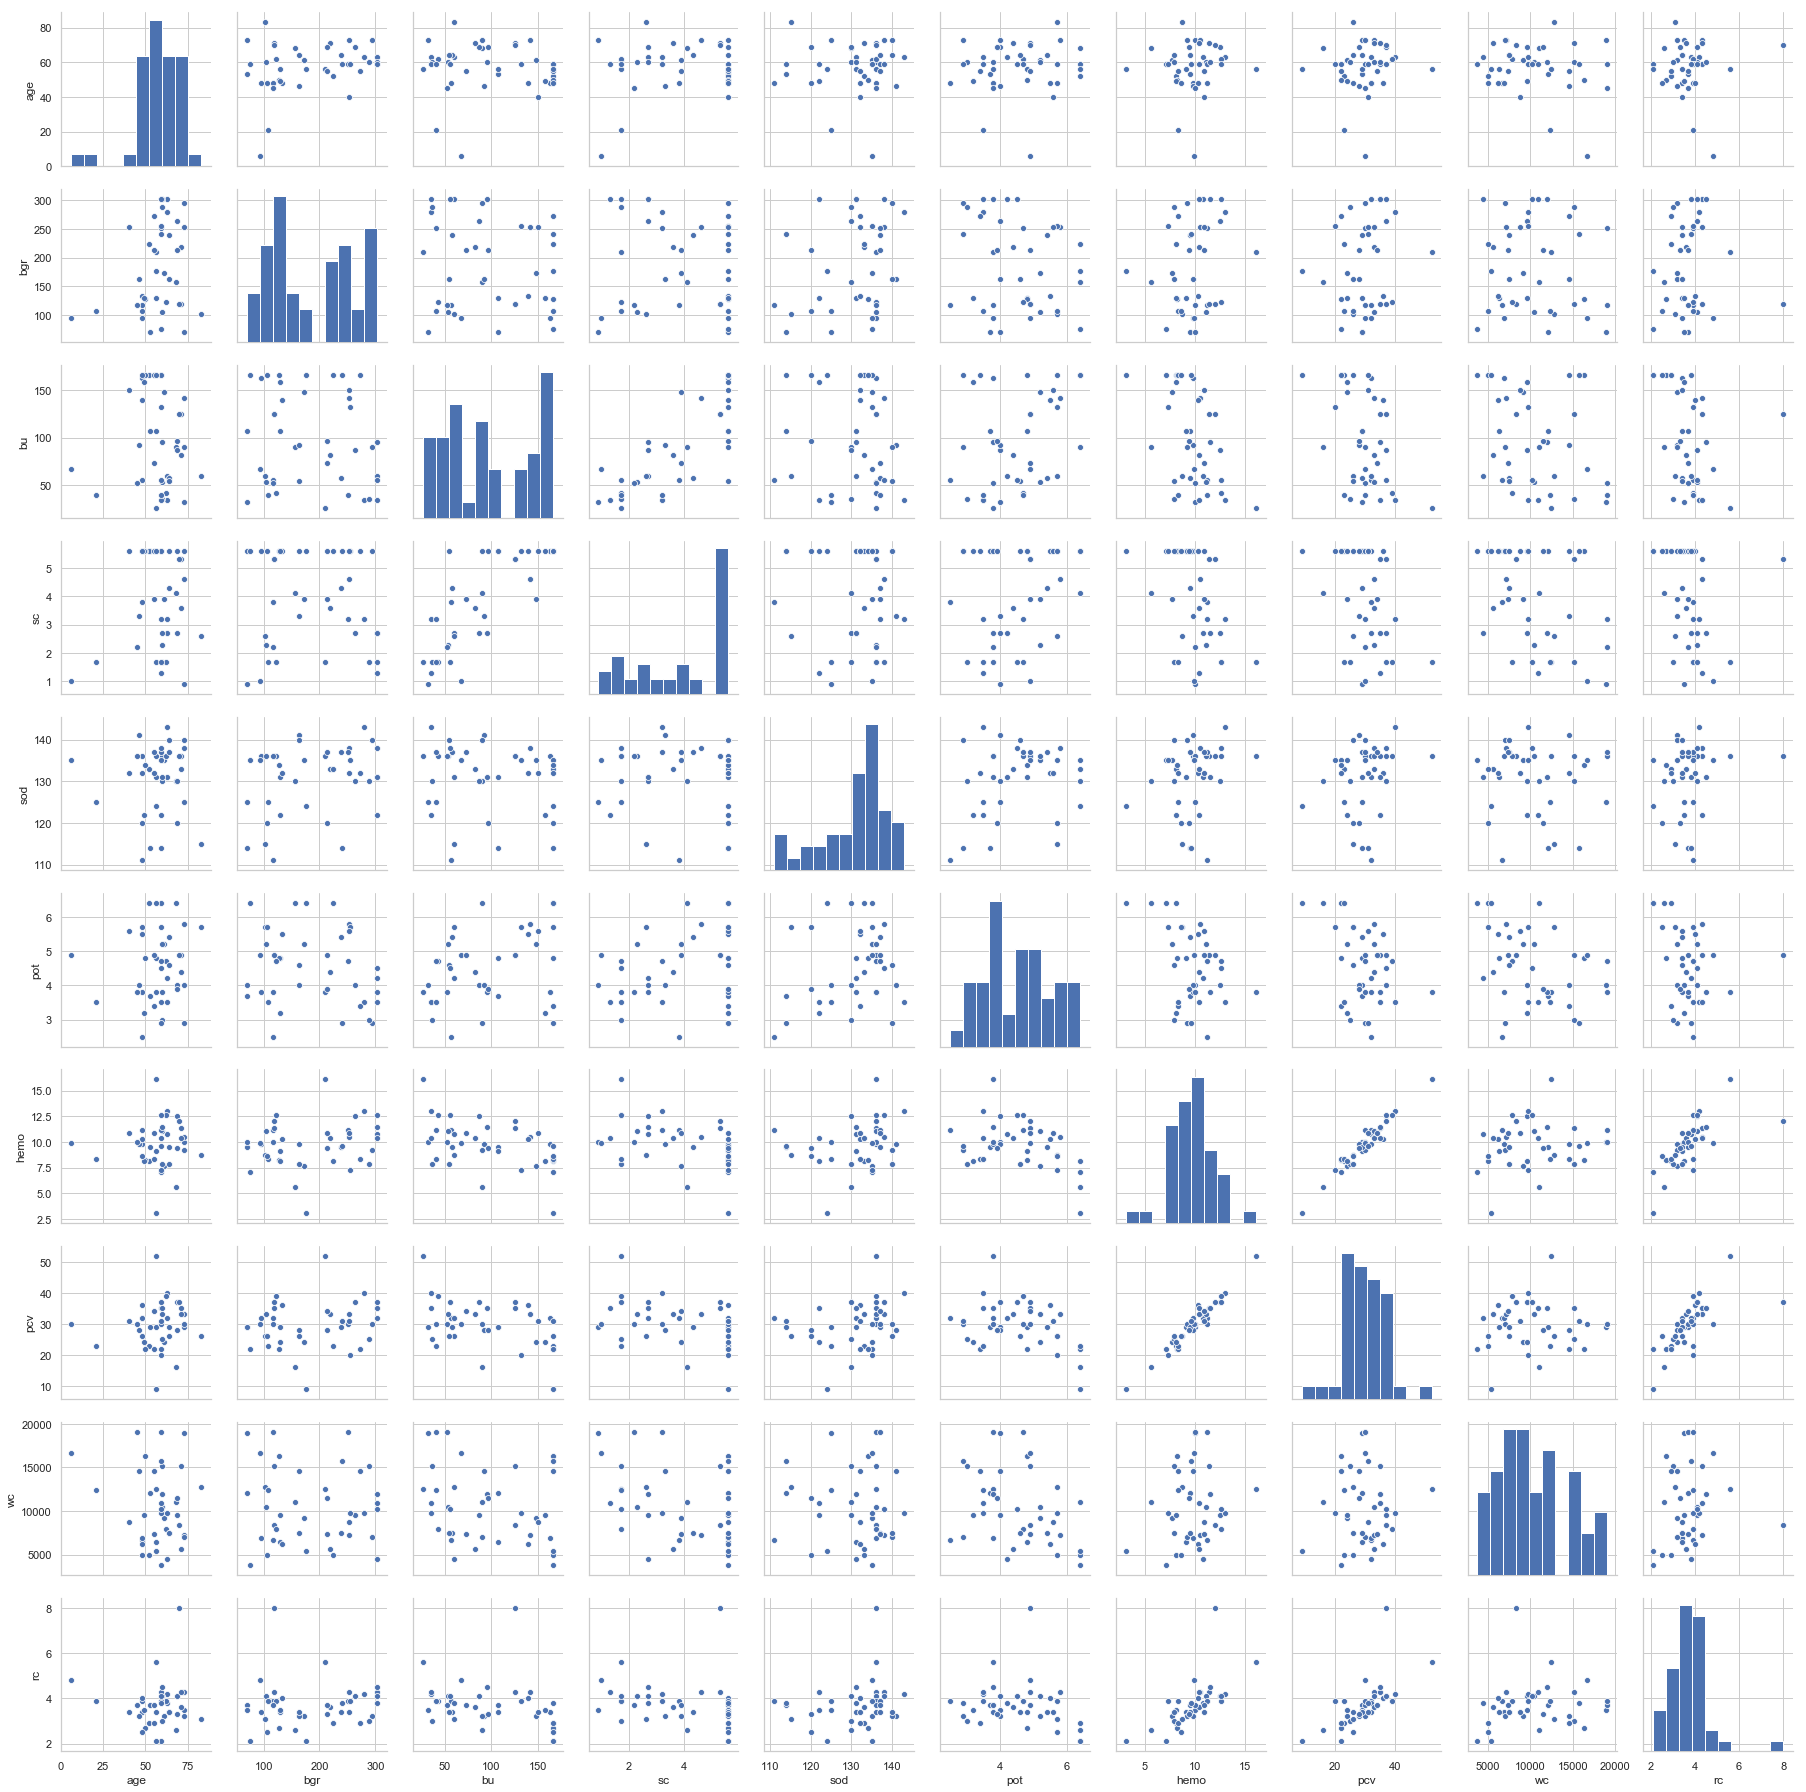

In [13]:
surekli_degiskenler=["age", "bgr", "bu", "sc", "sod", "pot", "hemo", "pcv", "wc", "rc"]

sns.pairplot(kd[surekli_degiskenler].where(kd["class"]==1))
plt.show()

Yukarıdaki grafikler incelendiğinde; potasyumun (pot) hemen hemen hiç bir değerle ilişkinin olmadığı görülmektedir. Ayrıca;

- Üre (bu) değeri ile Serum Kreatinin (sc) arasında doğrusal,
- Kırmızı Kan Sayımı (rc) ile Hemoglobin (hemo) ile Paket Hücre Hacmi (pcv) arasında doğrusal,
- Hemoglobin (hemo) ile Paket Hücre Hacmi (pcv) arasında doğrusal güçlü bir ilişki göze çarpmaktadır.

#### 4.c. Korelasyon tablosu
Bu değerler arasındaki ilişkileri daha iyi ve net anlayabilmek için korelasyonlarını görmekte fayda var.

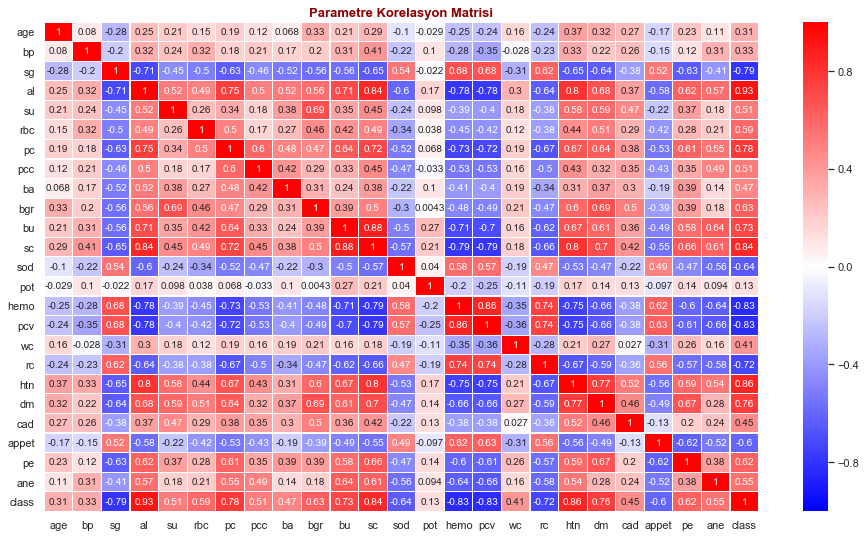

In [14]:
kd_wins_corr=kd_wins.corr()

plt.figure(figsize=(16,9))
sns.heatmap(kd_wins_corr, vmin=-1, vmax=1, cmap="bwr", annot=True, linewidth=0.1)
plt.title("Parametre Korelasyon Matrisi", fontdict=baslik_font)
plt.show()

Korelasyon değerleri, yukarıda gördüğümüz histogram ve pairplotu büyük ölçüde doğruluyor. Korelasyon tablosuna bakıldığında;

- Yaş (age), tansiyon (bp), potasyum (pot) ve beyaz kan sayımı (wc) parametrelerinin hastalıkla ilişkisi (ve diğer parametrelerle) yok denecek kadar az,

- Kan şekeri (su), kırmızı kan (rbc), irin kümesi sayısı (pcc), bakteri mevcudiyeti (ba) ve koroner arter hastalığının (cad) hastalıkla ilişkisi zayıf görünüyor.

Ancak, Hastalıkla;

- Albümin (al), irin (pc), üre (bu), serum kreatinin (sc), hipertansiyon (htn) ve diabetes mellitus (dm) parametreleri arasında güçlü pozitif yönlü,

- Kan özgül ağırlığı (sg), hemoglobin (hemo), paketlenmiş hücre hacmi (pcv) ve kırmızı kan sayımı (rc) parametreleri arasında güçlü negatif yönlü ilişki mevcuttur.

### 5. TEMEL BİLEŞENLER ANALİZİ (PCA)
Verilerimizi PCA işlemine tabi tutup, hastalık durumunu açıkllayabilmek için kaç tane özellik saklamamız gerektiğini inceleyelim:

In [15]:
kd_stdized=StandardScaler().fit_transform(kd)

pca = PCA(n_components=24)
pca.fit_transform(kd_stdized)

pca.explained_variance_ratio_

array([0.48884085, 0.07060996, 0.05654163, 0.04588866, 0.04294893,
       0.03839853, 0.03338256, 0.0302654 , 0.02717384, 0.02380723,
       0.01963123, 0.01767599, 0.01564263, 0.01503867, 0.01197156,
       0.01134504, 0.00952095, 0.0085379 , 0.00798771, 0.00658426,
       0.00550806, 0.00513601, 0.00393508, 0.00256667])

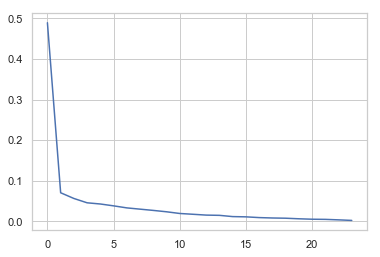

In [16]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

##### 43 hastanın parametreleri ile elde edilen sonuca göre:

Böbrek hastalığı ile ilgili toplam varyansın sadece % 47.9'u ilk bileşen tarafından açıklanabilmektedir.

Yukarıdaki değerlere göre:

>- 3 bileşen tuttuğumuzda, toplam varyansın ancak % 61.4 'ünü,
- 5 bileşen tuttuğumuzda, toplam varyansın ancak % 70.4 'ünü, açıklayabiliyoruz.


>- Toplam varyansın % 77.7 'sini açıklayabilmek için 7 bileşen,
- Toplam varyansın % 83.5 'ini açıklayabilmek için ise 9 bileşen tutmamız gerekiyor.

Yukarıdaki grafiğe baktığımızda, en uygun bileşen sayısı 3 ile 5 arasında değişebilmektedir.

### 6. SONUÇ
Korealasyon tablosuna bakıldığında, Kronik Böbrek Hastalığı ile ilişki yüksek olan (albümin değeri en yüksek) 11 adet özellik göze çarpmaktadır. Temel bileşenler analizi sonuçlarında ise varyansı % 2'den yüksek 11 adet özellik görülmektedir. PCA sonucunda, parametrelerin hedef değişkenini açıklama oranları ayrıştırılamayacak kadar fazladır.

Hastalık teşhisi konulmuş daha fazla değer elde edildiğinde daha kesin sonuçlar elde edilebilecektir.

Optimal bileşen sayısının 4 olabileceği (% 66.1) düşünülmektedir.